In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, SynopticSDOMLDataModule
from sdofm.pretraining import SAMAE
import numpy as np

In [3]:
import omegaconf

# cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae.yaml")
cfg = omegaconf.OmegaConf.load("../experiments/default.yaml")

In [5]:
data_module = SynopticSDOMLDataModule(
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.hmi
    ),
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    # os.path.join(
    #     cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    # ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=1,
    num_workers=cfg.data.num_workers,
    val_months=[],  # [1,2,3,4,5,6,7,8,9,10,11,12],
    test_months=[],
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
    num_frames=2760,
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [6]:
dl = torch.utils.data.DataLoader(
    data_module.train_ds,
    batch_size=data_module.batch_size,
    num_workers=data_module.num_workers,
    shuffle=False,
    drop_last=True,
)

In [12]:
import sunpy.visualization.colormaps as cm

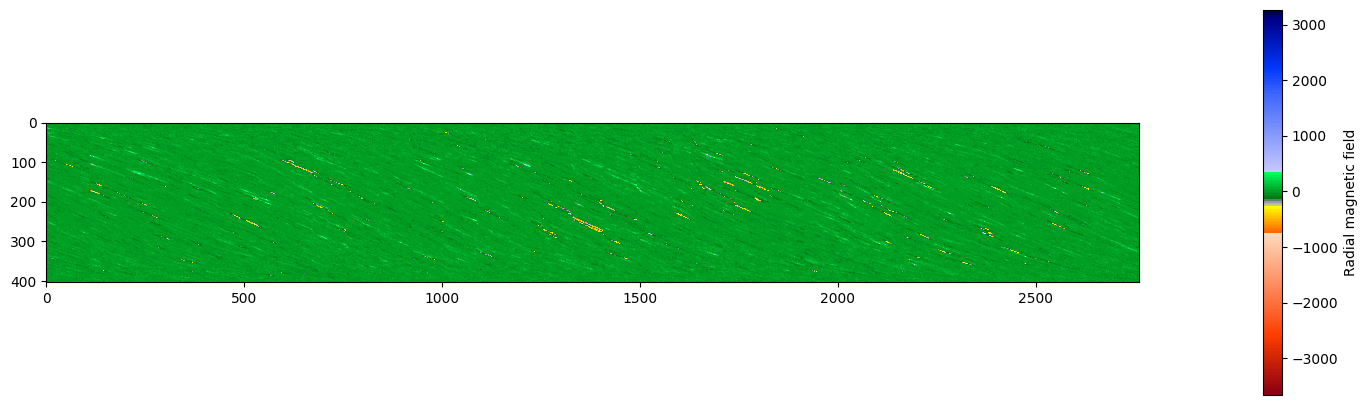

In [21]:
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16, 5))
# ax = plt.subplot(projection=syn_map)

out = band.reshape(band.shape[0], band.shape[1], band.shape[-1])[2, :, :].T * 100
im = plt.imshow(out, cmap=matplotlib.colormaps["hmimag"])
cb = plt.colorbar(im, fraction=0.019, pad=0.1)
cb.set_label(f"Radial magnetic field")
# ax.coords.grid(color="black", alpha=0.6, linestyle="dotted", linewidth=0.5)
plt.show()

In [3]:
import matplotlib.pyplot as plt

from astropy.utils.data import download_file

import sunpy.map

filename = download_file(
    'http://jsoc.stanford.edu/data/hmi/synoptic/hmi.Synoptic_Mr.2191.fits', cache=True)
syn_map = sunpy.map.Map(filename)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,carrington
Wavelength,6173.0 Angstrom
Observation Date,2017-06-09 10:56:34
Exposure Time,Unknown
Dimension,[3600. 1440.] pix
Coordinate System,heliographic_carrington
Scale,[0.1 0.07957747] deg / pix
Reference Pixel,[1799. 719.5] pix

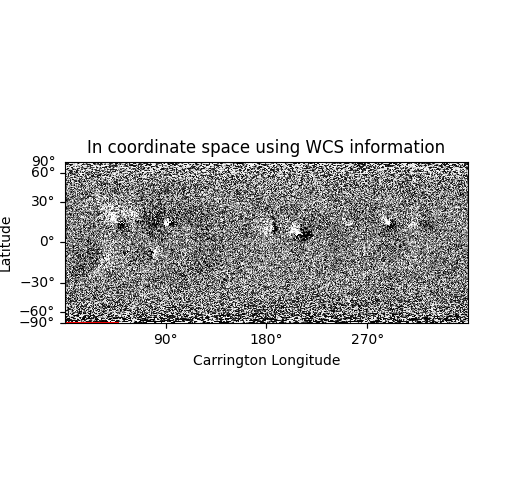
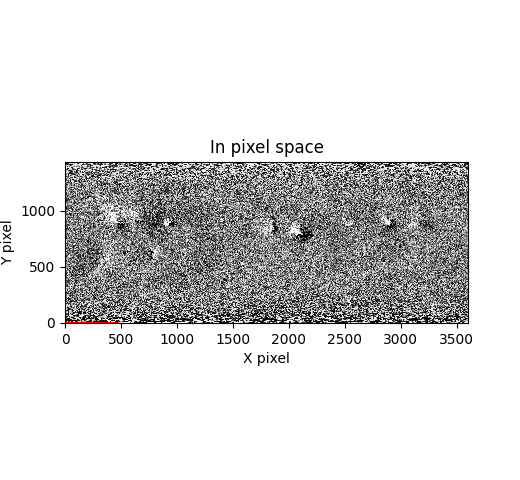
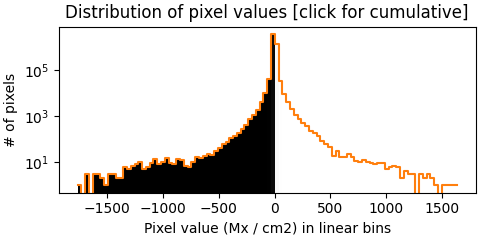
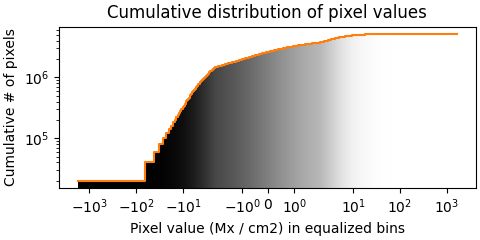

In [4]:
syn_map

In [5]:
from sunpy.data.sample import HMI_LOS_IMAGE

Observatory,SDO
Instrument,HMI FRONT2
Detector,HMI
Measurement,magnetogram
Wavelength,6173.0
Observation Date,2011-06-07 06:32:11
Exposure Time,Unknown
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.01714 2.01714] arcsec / pix
Reference Pixel,[511.5 511.5] pix

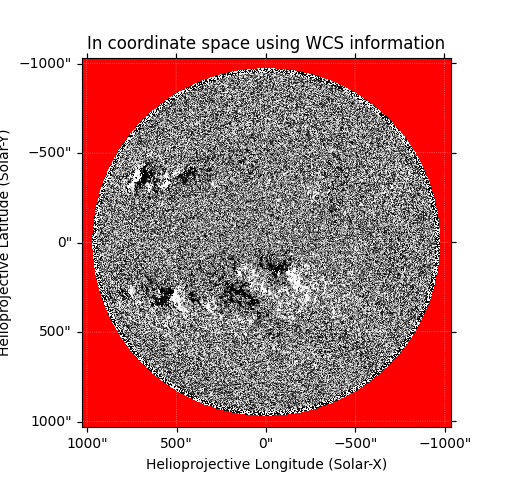
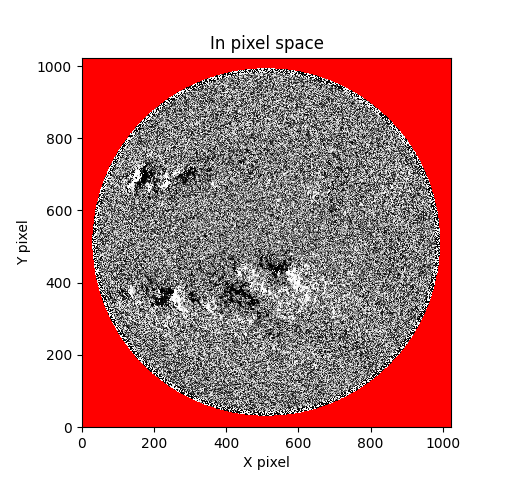
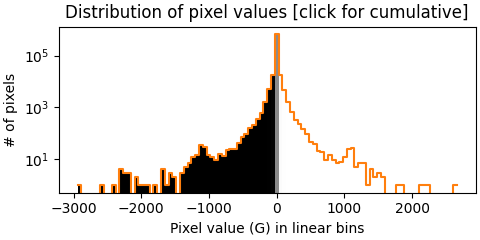
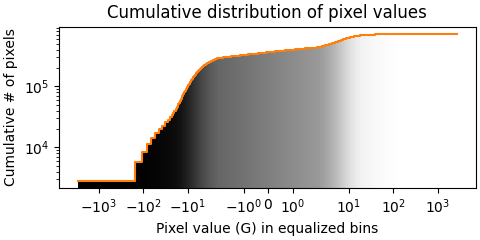

In [12]:
hmimap = sunpy.map.Map(HMI_LOS_IMAGE)
hmimap

In [10]:
from astropy.coordinates import SkyCoord

import sunpy.coordinates

import astropy.units as u

sc = SkyCoord(1*u.deg, 2*u.deg,
              frame="heliographic_carrington",
              observer="earth",
              obstime="2010/01/01T00:00:30")

Each 4096*4096 magnetogram is first transformed into a 'radial' field map by dividing by the cosine of the angle from disk center, i.e. we assume that the measured field is the line-of-sight component of a strictly radial field. This is done for high-quality magnetograms, viz. those with the QUALITY keyword tested for bits 0xfffefb00 and keyword TINTNUM>9, see Quality Definitions for more details.)

Next, the radial image is transformed into a high resolution map in heliographic coordinates. We exclude about 12 pixels near the limb (r < 0.994 Rs) to avoid the noisiest observations. To preserve something close to the disc-center resolution, we interpolate onto a 5403 * 4320 grid with columns corresponding to 1/30 of a degree in Carrington Longitude and rows corresponding to equal steps of sine latitude. Then each magnetogram is smoothed using a two-dimensional Gaussian with a full width at half max of 9 pixels that is truncated at a full width of 13 pixels. This results in a 1801 by 1440 heliographic map with the resolution of the final synoptic chart where the columns are aligned to 0.1 degree Carrington longitude centers and rows are equally spaced in sine latitude.

Each point in the final synoptic chart combines data from 20 transformed radial magnetograms. Good data observed nearest central meridian are averaged. Typically this includes magnetogram data collected within 2 hours of central meridian passage. We perform an additional quality test at each point by excluding observations that are more than 3 standard deviations from the mean of the 30 perfect-quality magnetograms observed nearest central meridian. Data values observed farther from central meridian are used to replace bad values. The number of magnetograms contributing to each point is recorded in the epts segment of the data series. Except at high latitude where the poles are not visible, it is rare for there to be other than 20 contributing values. 

In [ ]:
interpol_x = 5403
interpol_y = 4320
a_map = np.zeros(5403, 4320)
for 

In [13]:
x, y = hmimap.world_to_pixel(sc)

In [14]:
x,y

(<Quantity 503.56935071 pix>, <Quantity 502.8815269 pix>)